# **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.pyplot as plt
from scipy import ndimage

# **Loading the data**

In [2]:
# Loading the data
df_train=pd.read_csv("../input/train.csv")

In [3]:
# Looking at the shape of the data
df_train.shape

(42000, 785)

In [4]:
# Getting the features from the train data frame by dropping label from the data frame
df_X=df_train.drop("label",axis=1)

**Function to calculate moments of the image data.**


This function, moments(image), calculates the spatial moments of an image. Spatial moments are statistical measures that provide information about the distribution of pixel intensities in an image.

In [5]:
def moments(image):
    # Creates two grids, c0 and c1, representing the row and column indices of the image, respectively. 
    # This is a trick in NumPy to create a mesh grid spanning the dimensions of the image.
    c0, c1 = np.mgrid[:image.shape[0], :image.shape[1]]
    
    # Computes the sum of all pixel intensities in the image, which represents the total intensity of the image.
    totalImage = np.sum(image)  
    
    # Calculate the first-order spatial moments, which represent the centroid of the image along the x and y axes, respectively.
    m0 = np.sum(c0 * image) / totalImage  
    m1 = np.sum(c1 * image) / totalImage  
    
    # Calculate the second-order spatial moments, which represent the variance of pixel intensities along the x and y axes, respectively.
    m00 = np.sum((c0 - m0) ** 2 * image) / totalImage  
    m11 = np.sum((c1 - m1) ** 2 * image) / totalImage  
    
    # Calculates the covariance between pixel intensities along the x and y axes
    m01 = np.sum((c0 - m0) * (c1 - m1) * image) / totalImage  # covariance(x,y)
    
    mu_vector = np.array([m0, m1])
    
    covariance_matrix = np.array([[m00, m01], [m01, m11]]) 
    
    return mu_vector, covariance_matrix

# The function returns mu_vector, which contains the centroid coordinates, and covariance_matrix, 
# which contains information about the spread and orientation of pixel intensities in the image.

In [6]:
# Sample image (assuming X_train contains the image data)
sample_image = df_X.iloc[0]

# Print the shape of sample_image
print("Shape of sample_image:", sample_image.shape)

Shape of sample_image: (784,)


In [7]:
# Reshape sample_image into a 28x28 array
sample_image_reshaped = sample_image.reshape(28, 28)

# Compute moments
mu_vector, covariance_matrix = moments(sample_image_reshaped)

# Print centroid coordinates
print("Centroid:", mu_vector)

# Print covariance matrix
print("Covariance Matrix:")
print(covariance_matrix)

Centroid: [13.57462911 13.9672653 ]
Covariance Matrix:
[[ 30.62223096 -21.02611731]
 [-21.02611731  15.76437982]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


**This function, deskew(image), is used to deskew (correct the skewness of) an image by applying an affine transformation.**

When we write, we often write at angles to the paper, which cause letters and numbers to be skewed. Unfortunately, unlike the human eye, computers cannot easily find similarities between images that are transformations of each other. Thus, the process of deskewing.

**Deskewing is the process of straightening an image that has been scanned or written crookedly — that is an image that is slanting too far in one direction, or one that is misaligned.**

In particular, we model the process of deskewing as an affine transformation. We assume that when the image was created (the skewed version), it is actually some affine skew transformation on the image $Image' = A(Image) + b$, which we do not know. What we do know is that we want the center of mass to be the center of the image, and that we'd like to know the angle at which it was skewed.

The **methodology** goes as follows:

1) Find the center of mass of the image to figure out how much we need to offset the image.

2) Find the covariance matrix of the image pixel intensities (we can use this to approximate the skew of the angle).

The function **moments** we've defined before, calculates these relevant quantities.

Next, we'd like to calculate the matrix which will allow us to skew "back" to the original image. This is given by the following formula:

\
\begin{bmatrix}
1 & \alpha \\
0 & 1
\end{bmatrix}


where $\alpha = \frac{\text{Cov}(X,Y)}{\text{Var}(X)}$.

Furthermore, we have an offset of $\mu - \text{center}$.

In [8]:
def deskew(image):
    # Calculates the centroid (c) and covariance matrix (v) of the input image
    c,v = moments(image)
    
    # Computes the skewness angle (alpha) by dividing the covariance between x and y (v[0, 1]) by the variance along the x-axis (v[0, 0]). 
    # This angle represents the degree of skewness in the image.
    alpha = v[0,1]/v[0,0]
    
    # Constructs an affine transformation matrix. 
    # Affine transformations preserve straight lines and angles but allow for translation, rotation, scaling, and skewing.
    affine = np.array([[1,0],[alpha,1]])
    
    # Computes the coordinates of the center of the image.
    ocenter = np.array(image.shape)/2.0
    
    # Calculates the offset needed to reposition the centroid (c) to the center of the image after applying the affine transformation. 
    # This offset ensures that the image remains centered after deskewing.
    offset = c-np.dot(affine,ocenter)
    
    return ndimage.affine_transform(image, affine, offset=offset)

In [9]:
# Define the examples
examples = [(4181, 0), (3, 1), (56282, 2), (25829, 3), (9741, 4), (26901, 5), (50027, 6), (17935, 7), (41495, 8), (14662, 9)]

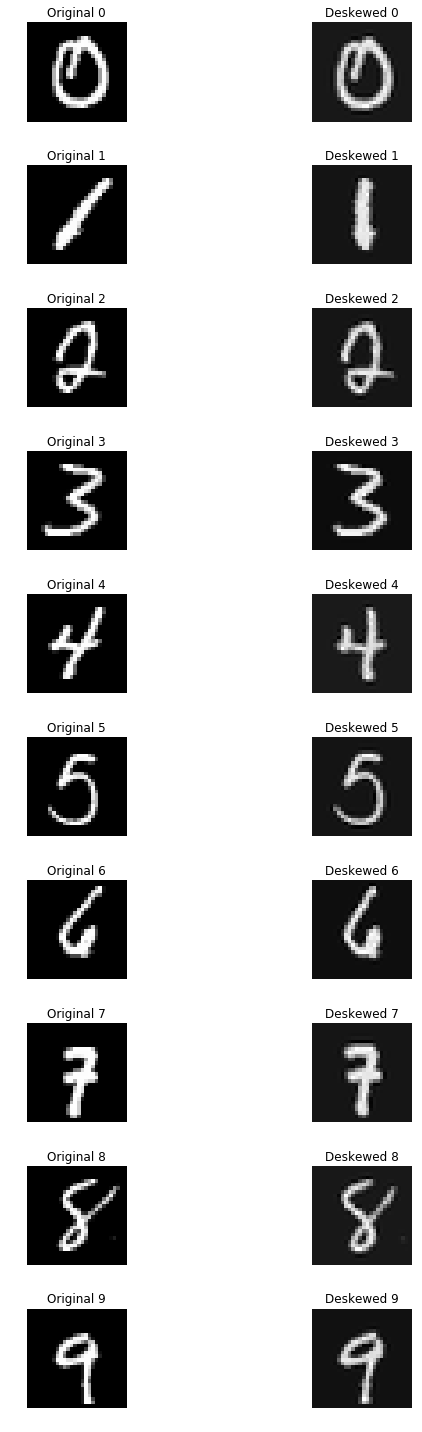

In [10]:
# Define a function to get one random example for each digit
def get_random_example_for_digit(digit):
    # Get indices of examples with the specified digit
    digit_indices = df_train[df_train['label'] == digit].index
    # Randomly select one index
    random_index = np.random.choice(digit_indices)
    # Return the image data corresponding to the randomly selected index
    return df_train.iloc[random_index, 1:].values

# Create a list to store one random example for each digit
random_examples = []

# Iterate over digits 0 to 9 and get one random example for each digit
for digit in range(10):
    random_examples.append(get_random_example_for_digit(digit))

# Create the figure and grid layout
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

# Iterate over random examples and plot the original and deskewed images
for digit, (orig_img, ax_orig) in enumerate(zip(random_examples, axes[:, 0])):
    # Plot the original image
    ax_orig.imshow(orig_img.reshape(28, 28), cmap='gray')
    ax_orig.set_title(f'Original {digit}')
    ax_orig.axis('off')

    # Plot the deskewed image
    ax_deskewed = axes[digit, 1]
    ax_deskewed.imshow(deskew(orig_img.reshape(28, 28)), cmap='gray')
    ax_deskewed.set_title(f'Deskewed {digit}')
    ax_deskewed.axis('off')

plt.tight_layout()
plt.show()

The formula used by the affine_transform function can be expressed as:

**output = matrix × o + offset**

Here's what each part of the formula represents:

**matrix:** This represents the affine transformation matrix, which describes the linear transformation to be applied to the input image. It includes operations such as rotation, scaling, shearing, and reflection.

**o:** This is the input image pixel index vector. It represents the coordinates of each pixel in the input image.

**offset:** This parameter represents the translation offset to be applied to the image. It accounts for the displacement needed to reposition the transformed image correctly.

In [11]:
# Function for scaling the data between 0 and 1
def scale(vect):
    return (vect-vect.min())/(vect.max()-vect.min())

In [12]:
# Deskewing the data
df_X=df_X.apply(lambda x: deskew(x.reshape(28,28)).flatten(),axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [13]:
# Scaling the data
X=df_X.apply(scale)

In [14]:
# Dropping all the columns with only NaN values
X=X.dropna(axis=1,how='all')

In [15]:
# Saving the label data as the target variable
y=df_train["label"]

In [16]:
# Observing first few lines of the features data frame
X.head()

,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,...,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781
0,0.0,0.0,0.0,0.333333,0.777778,0.769231,0.666667,0.8,0.705882,0.761905,...,0.16,0.358491,0.6250,0.684211,0.666667,0.761905,0.75,0.846154,0.5,0.0
1,0.0,0.0,0.0,0.333333,0.777778,0.769231,0.666667,0.8,0.705882,0.761905,...,0.16,0.377358,0.6875,0.684211,0.666667,0.761905,0.75,0.846154,0.5,0.0
2,0.0,0.0,0.0,0.333333,0.777778,0.769231,0.666667,0.8,0.705882,0.761905,...,0.16,0.377358,0.6875,0.684211,0.666667,0.761905,0.75,0.846154,0.5,0.0
3,0.0,0.0,0.0,0.333333,0.777778,0.769231,0.666667,0.8,0.705882,0.761905,...,0.16,0.377358,0.6875,0.684211,0.666667,0.761905,0.75,0.846154,0.5,0.0
4,0.0,0.0,0.0,0.333333,0.777778,0.769231,0.666667,0.8,0.705882,0.761905,...,0.16,0.377358,0.6875,0.684211,0.666667,0.761905,0.75,0.846154,0.5,0.0


In [17]:
# Splitting the data into test and training set for our first simple linear SVM testing
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)

In [18]:
# Creating our linear SVM object
from sklearn.svm import SVC

clf=SVC(C=1,kernel="linear")

* **C:** This parameter represents the **regularization parameter**. In SVM, C controls the **trade-off** between maximizing the margin and minimizing the classification error. A smaller value of C leads to a larger margin but may result in more misclassifications, while a larger value of C allows for fewer misclassifications but may lead to a smaller margin. 

In this case, C is set to 1, meaning it is using the default regularization strength.


* **kernel:** This parameter specifies the **type of kernel** to be used in the SVM algorithm. Since you're creating a linear SVM, the kernel is set to "linear". 

The linear kernel computes the dot product between the input features and is suitable for **linearly separable data.** It's commonly used when the data can be separated by a straight line or plane in the input space.

In [19]:
# Fitting the training data in the SVM object

clf.fit(train_x,train_y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
# Saving the predictions on the test set 

y_predict=clf.predict(test_x)

In [21]:
# Measuring the accuracy of our predictions

from sklearn import metrics

accuracy=metrics.accuracy_score(test_y,y_predict)
print(accuracy)

0.9607936507936508


As evident from the previous results, we achieved a commendable accuracy of **96%** using a **basic linear SVM model** without any hyperparameter tuning. We will now proceed with performing PCA decomposition to explore the potential for further accuracy enhancement.

**This function is designed to perform PCA (Principal Component Analysis) decomposition on the input data and evaluate the performance of a Support Vector Machine (SVM) classifier with different levels of PCA components.**

In [22]:
from sklearn.decomposition import PCA

def n_component_analysis(n,X_train, y_train, X_val, y_val,kernel_type="linear"):
   
    # The function initializes a PCA object with the specified number of components (n) and fits it to the training data (X_train).
    pca = PCA(n_components=n)
    print("PCA begin with n_components: {}".format(n))
    pca.fit(X_train)

    # It then transforms both the training and validation data into the reduced-dimensional space using the fitted PCA model.
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)

    print('SVC begin')
    # After PCA decomposition, the function initializes an SVM classifier (clf1) with the specified kernel type (default is linear).
    # It fits the SVM classifier to the training data transformed by PCA (X_train_pca) and the corresponding labels (y_train).
    clf1 = SVC(kernel=kernel_type)
    clf1.fit(X_train_pca, y_train)
    
    # The classifier is then used to predict the labels for the validation data transformed by PCA (X_val_pca).
    predictions=clf1.predict(X_val_pca)
    accuracy = metrics.accuracy_score(y_val,predictions)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

By repeatedly calling this function with different numbers of components (n), one can analyze how the performance of the SVM classifier varies with different levels of PCA decomposition. **This helps in determining the optimal number of components to achieve the desired balance between dimensionality reduction and classification accuracy.**

In [23]:
# Calling the PCA function above where kernel is linear by default and see if we can improve our accuracy
n_s = np.linspace(0.70, 0.85, num=15)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n,train_x, train_y, test_x, test_y)
    accuracy.append(tmp)

PCA begin with n_components: 0.7
SVC begin
accuracy: 0.9446825396825397
PCA begin with n_components: 0.7107142857142856
SVC begin
accuracy: 0.9451587301587302
PCA begin with n_components: 0.7214285714285714
SVC begin
accuracy: 0.9473809523809524
PCA begin with n_components: 0.7321428571428571
SVC begin
accuracy: 0.947936507936508
PCA begin with n_components: 0.7428571428571428
SVC begin
accuracy: 0.947936507936508
PCA begin with n_components: 0.7535714285714286
SVC begin
accuracy: 0.9506349206349206
PCA begin with n_components: 0.7642857142857142
SVC begin
accuracy: 0.9507142857142857
PCA begin with n_components: 0.7749999999999999
SVC begin
accuracy: 0.9533333333333334
PCA begin with n_components: 0.7857142857142857
SVC begin
accuracy: 0.9555555555555556
PCA begin with n_components: 0.7964285714285714
SVC begin
accuracy: 0.9571428571428572
PCA begin with n_components: 0.8071428571428572
SVC begin
accuracy: 0.9574603174603175
PCA begin with n_components: 0.8178571428571428
SVC begin
ac

**Although we did not achieve a significant improvement in performance, let's explore the use of the 'rbf' kernel to see if it can enhance our results.**

In [24]:
del accuracy
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n,train_x, train_y, test_x, test_y,"rbf")
    accuracy.append(tmp)

PCA begin with n_components: 0.7
SVC begin
accuracy: 0.9761904761904762
PCA begin with n_components: 0.7107142857142856
SVC begin
accuracy: 0.9757936507936508
PCA begin with n_components: 0.7214285714285714
SVC begin
accuracy: 0.978015873015873
PCA begin with n_components: 0.7321428571428571
SVC begin
accuracy: 0.9788095238095238
PCA begin with n_components: 0.7428571428571428
SVC begin
accuracy: 0.9791269841269842
PCA begin with n_components: 0.7535714285714286
SVC begin
accuracy: 0.9788888888888889
PCA begin with n_components: 0.7642857142857142
SVC begin
accuracy: 0.9786507936507937
PCA begin with n_components: 0.7749999999999999
SVC begin
accuracy: 0.9782539682539683
PCA begin with n_components: 0.7857142857142857
SVC begin
accuracy: 0.9789682539682539
PCA begin with n_components: 0.7964285714285714
SVC begin
accuracy: 0.9792063492063492
PCA begin with n_components: 0.8071428571428572
SVC begin
accuracy: 0.979047619047619
PCA begin with n_components: 0.8178571428571428
SVC begin
ac

In [25]:
# Printing the results
print("Accuracy with 'rbf' kernel:", accuracy)

Accuracy with 'rbf' kernel: [0.9761904761904762, 0.9757936507936508, 0.978015873015873, 0.9788095238095238, 0.9791269841269842, 0.9788888888888889, 0.9786507936507937, 0.9782539682539683, 0.9789682539682539, 0.9792063492063492, 0.979047619047619, 0.9794444444444445, 0.9795238095238096, 0.9785714285714285, 0.9780952380952381]


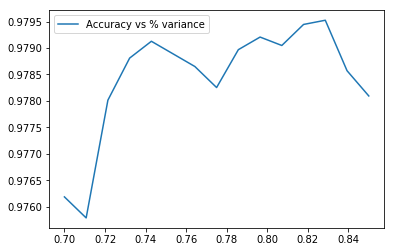

In [26]:
# Plotting the accuracy vs % variance 
import matplotlib.pyplot as plt

plt.figure()
plt.plot(n_s,np.array(accuracy),label='Accuracy vs % variance')
plt.legend()
plt.show()

The plot above indicates that the accuracy peaks around **n=0.83**. Therefore, we will use this value for our PCA decomposition. Next, we can conduct a **grid search** to **fine-tune hyperparameters such as 'gamma' and 'C'**. Note that this process may take a considerable amount of time. One can uncomment this section to perform hyperparameter tuning themselves.

In [27]:
# Doing 4 fold cross validation for hyper parameter tuning
#from sklearn.model_selection import GridSearchCV
#n_fold=4
#param={'C':[1,10,20],'gamma':[0.0001,0.001,0.01]}
#model=SVC(kernel='rbf')

#clf2=GridSearchCV(estimator=model,param_grid=param,cv=n_fold,verbose=1,return_train_score=True,scoring="accuracy")
#clf2.fit(X,y)

In [28]:
# Printing results from Gridsearch
#cv_results = pd.DataFrame(clf2.cv_results_)
#cv_results.sort_values('mean_test_score',ascending=False)

**Do the PCA transform with n=0.83 and after that fitting a 'rbf' kernel with C=20 and gamma=0.001**

In [29]:
pca = PCA(n_components=0.83)
pca.fit(train_x)
X_train_pca = pca.transform(train_x)
X_val_pca = pca.transform(test_x)

clf1 = SVC(kernel="rbf",C=20,gamma=0.01)
clf1.fit(X_train_pca,train_y)
predictions=clf1.predict(X_val_pca)
metrics.accuracy_score(test_y,predictions)

0.9812698412698413